In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta

# Number of entries
num_entries = 100_000

# Possible colony locations
locations = ["Boulders Beach", "Stony Point", "Dassen Island", "Robben Island", "Bird Island"]

# Generate random timestamps within a 2-year range
start_time = datetime(2022, 1, 1)
timestamps = [start_time + timedelta(minutes=random.randint(0, 2 * 365 * 24 * 60)) for _ in range(num_entries)]

# Generate RFID tags (10-digit numbers)
rfids = [f'{random.randint(1000000000, 9999999999)}' for _ in range(num_entries)]

# Weights (in grams), normally distributed around 3000g ± 300g
weights = np.random.normal(loc=3000, scale=300, size=num_entries).clip(1800, 4500)

# Sex (some may be unknown)
sexes = np.random.choice(['M', 'F', 'Unknown'], size=num_entries, p=[0.45, 0.45, 0.1])

# Age category
age_categories = np.random.choice(['Chick', 'Juvenile', 'Adult'], size=num_entries, p=[0.2, 0.3, 0.5])

# Measurement validity (simulate some invalid entries)
valid_flags = np.random.choice([True, False], size=num_entries, p=[0.95, 0.05])

# Locations
colony_locations = np.random.choice(locations, size=num_entries)

# Construct DataFrame
df = pd.DataFrame({
    'timestamp': timestamps,
    'location': colony_locations,
    'rfid': rfids,
    'weight_g': weights.astype(int),
    'sex': sexes,
    'age_category': age_categories,
    'valid_measurement': valid_flags
})

# Save to CSV
df.to_csv("dummy_penguin_weights_100k.csv", index=False)
print("100k-entry dummy dataset saved as 'dummy_penguin_weights_100k.csv'")


100k-entry dummy dataset saved as 'dummy_penguin_weights_100k.csv'


In [55]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
import pandas as pd
import joblib

# Load and preprocess
df = pd.read_csv("dummy_penguin_weights_100k.csv")
df = df[df['valid_measurement'] == True]

# Select features
X = df[['weight_g']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train Isolation Forest
model = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)
model.fit(X_scaled)

# Predict anomalies
df['anomaly'] = model.predict(X_scaled)  # -1 = anomaly, 1 = normal
alerts = df[df['anomaly'] == -1]

# Show sample alerts
print(alerts[['timestamp', 'rfid', 'weight_g', 'location']])

# Save both the model and the scaler
joblib.dump(model, 'isolation_forest_model.pkl')
joblib.dump(scaler, 'scaler.pkl')


                 timestamp        rfid  weight_g        location
17     2022-08-14 09:53:00  8269433501      1843   Dassen Island
50     2023-09-20 23:31:00  2583646447      3742  Boulders Beach
71     2023-12-07 08:26:00  3726796270      2207     Stony Point
112    2022-07-08 06:56:00  5497645927      2251     Stony Point
164    2023-10-21 05:43:00  5826648923      3849  Boulders Beach
...                    ...         ...       ...             ...
99358  2022-10-12 08:55:00  3552832080      3729   Dassen Island
99697  2022-02-13 13:46:00  9135556385      3781     Bird Island
99726  2023-03-01 11:52:00  2994103840      3709     Stony Point
99743  2022-10-22 12:53:00  7787172225      3793   Robben Island
99825  2023-02-03 16:25:00  3298677629      3735     Stony Point

[1897 rows x 4 columns]


['scaler.pkl']

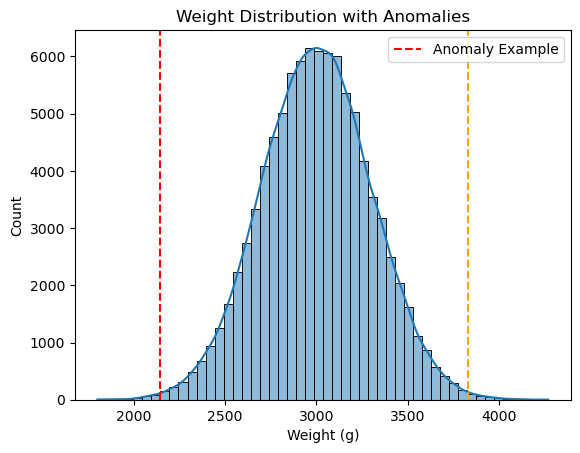

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['weight_g'], kde=True, bins=50)
plt.axvline(2141, color='r', linestyle='--', label='Anomaly Example')
plt.axvline(3828, color='orange', linestyle='--')
plt.legend()
plt.title("Weight Distribution with Anomalies")
plt.xlabel("Weight (g)")
plt.show()

In [53]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import IsolationForest

# Assume df is your DataFrame already loaded with columns: timestamp, location, rfid, weight_g, sex, age_category

# 1. Extract time features
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['hour_of_day'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek

# 2. Define categorical and numerical columns
categorical_cols = ['location', 'sex', 'age_category']
numerical_cols = ['weight_g', 'hour_of_day', 'day_of_week']

# 3. Create preprocessing pipeline: one-hot encode categorical, scale numerical
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numerical_cols)
    ])

# 4. Fit and transform the data
X = preprocessor.fit_transform(df)

# Note: X is a sparse matrix if OneHotEncoder returns sparse; convert to dense if needed
if hasattr(X, "toarray"):
    X = X.toarray()

# 5. Train Isolation Forest model
model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
model.fit(X)

# 6. Predict anomalies (-1 = anomaly, 1 = normal)
df['anomaly'] = model.predict(X)

# 7. Extract anomalies
anomalies = df[df['anomaly'] == -1]

# 8. Show some anomalies
print(anomalies[['timestamp', 'location', 'rfid', 'weight_g']].head())


              timestamp       location        rfid  weight_g
152 2023-07-02 09:21:00    Bird Island  9120343291      3169
433 2023-06-05 04:50:00    Stony Point  3059659961      3199
441 2023-07-31 01:09:00  Robben Island  3967035459      3199
534 2023-10-29 11:06:00    Bird Island  3075553208      3469
780 2023-08-27 16:53:00    Bird Island  5416555556      2579


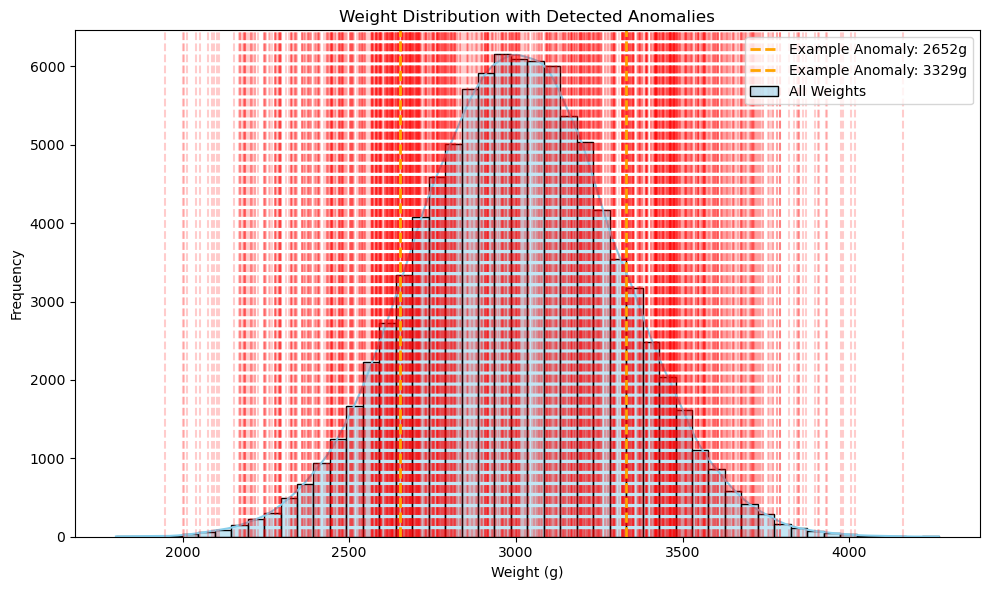

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create the histogram of all weights
plt.figure(figsize=(10, 6))
sns.histplot(df['weight_g'], kde=True, bins=50, color='skyblue', label='All Weights')

# 2. Overlay vertical lines for detected anomalies
for w in anomalies['weight_g']:
    plt.axvline(w, color='red', linestyle='--', alpha=0.2)  # faint lines for anomaly weights

# 3. Highlight two example anomaly weights (optional)
example_weights = anomalies['weight_g'].sample(2, random_state=42)
for w in example_weights:
    plt.axvline(w, color='orange', linestyle='--', linewidth=2, label=f'Example Anomaly: {w}g')

# 4. Final touches
plt.title("Weight Distribution with Detected Anomalies")
plt.xlabel("Weight (g)")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
